# TTC Subway Delay - Exploratory Data Analysis

When doing data projects, I often focus on topics and datasets that are familiar to me. As a Torontonian, there is nothing more familiar than Toronto Transit Commission (TTC) delays.  If you live in Toronto and have taken transit, you've felt the frustration of the TTC delays.  

The TTC has releases data monthly about delays on buses, streetcars and subways on the [Toronto Open Data Portal](https://open.toronto.ca/catalogue/?topics=Transportation&owner_division=Toronto%20Transit%20Commission).  I mostly use the subway, so I decided to focus on [subway data](https://open.toronto.ca/dataset/ttc-subway-delay-data/). In this project, I'll explore the data to see what are the most common delays? Where and when do they occur? And, has the number been changing over time? In a future project, I'll use what I"ve learned to build a model to predict the length of delays. Because every commuter would love to peek into the cab of the subway car and get some clues about whether they will arrive on time today?


**Data selection and extraction**
- I selected two years worth of data as I thought it would be useful to have multiple years to explore trends
- I decided to focus on pre-pandemic data (2018, 2019) to limit any skew from the slowdowns in TTC during COVID closures
- *Data extraction method for the data files*
    - I downloaded the files for 2018 and 2019 
    - The files are in excel format with data spread across sheets. The sheets have a consistent structure but inconsistent naming convention
    - I looped through the downloaded file list and extracted data from each sheet, then combined it into a single dataframe
    - Finally, I exported the joined data set for validation and future access
- *Data extraction method for the code description*
    - A code dictionary was included in the TTC subway delay data set. 
    - The code dictionary is as a formatted table in an xlsx document
    - I extracted relevant rows and columns to merge with the other data

## Import packages and define notebook settings

In [1]:
#data cleaning and structure
import pandas as pd
import numpy as np
import os
from skimpy import clean_columns #clean column names
import datetime 

#graphs
import seaborn as sns #a library for ploting graphs that cmplements matplot.lib
import matplotlib.pyplot as plt # library for visuals
import matplotlib as mpl

#modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import and clean data

In [2]:
#create a list of the filenames with data to be extracted
filenames = ["ttc-subway-delay-data-2018.xlsx", "ttc-subway-delay-data-2019.xlsx"]

#create a dummy dataframe where the data will be stored and combined
final_df = pd.DataFrame()

#loop through the files in the filename list
for file in filenames:
    #create list of all sheets in the file
    sheet = pd.ExcelFile("Data/"+file)
    myWorksheets = sheet.sheet_names
    myWorksheets
          
    #read all the sheets from the file and create a seperate excel for each year
    for sheet in myWorksheets:
        df = pd.read_excel("Data/"+file,sheet_name=sheet)
        final_df = pd.concat([final_df, df])
final_df.to_excel("Data/combined/combined.xlsx",index=False)



In [3]:
#clean the column names for the final_df
final_df = clean_columns(final_df)
final_df.head()

10 column names have been cleaned

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


In [4]:
#code dictionary data 
#ignore the extra rows and colums that aren't needed in the excel sheet
delay_raw = pd.read_excel("Data/ttc-subway-delay-codes.xlsx", header=1, usecols=[2,3,6,7])

#clean column names
delay_raw = clean_columns(delay_raw)

#reorganize the data in the excel sheet into two columns
sub_rmenu = delay_raw.iloc[:,[0,1]].rename(columns={'sub_rmenu_code':'code'})
srt_rmenu = delay_raw.iloc[:,[2,3]].rename(columns={'srt_rmenu_code':'code', 'code_description_1':'code_description'})

#add a column for the type of vehicle, which was previously shown by the different columns
sub_rmenu['v_type'] = 'sub'
srt_rmenu['v_type'] = 'sub'

delay = pd.concat([sub_rmenu, srt_rmenu])
delay.head()

4 column names have been cleaned

,code,code_description,v_type
0,EUAC,Air Conditioning,sub
1,EUAL,Alternating Current,sub
2,EUATC,ATC RC&S Equipment,sub
3,EUBK,Brakes,sub
4,EUBO,Body,sub


In [5]:
#different codes mean the same thing for the subway and the scarborough rapid transit 
#so join the code description to the final df, that way you can group on the different values
final_df = final_df.merge(delay.iloc[:,[0,1]], how='left', on='code')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39959 entries, 0 to 39958
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39959 non-null  datetime64[ns]
 1   time              39959 non-null  object        
 2   day               39959 non-null  object        
 3   station           39959 non-null  object        
 4   code              39959 non-null  object        
 5   min_delay         39959 non-null  int64         
 6   min_gap           39959 non-null  int64         
 7   bound             30879 non-null  object        
 8   line              39808 non-null  object        
 9   vehicle           39959 non-null  int64         
 10  code_description  39135 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 3.7+ MB


*Additional cleaning and formatting*
- the time column is an hour/min column but is formatted as a string.  Convert it to datetime
- the vehicle column is an integer, but it actually represents a code for a vehicle or station
- set up day as categorical with an order

In [6]:
# time of day 
final_df['time'] = pd.to_datetime(final_df['time'],format='%H:%M').dt.strftime("%H:%M")

#convert vehicle to a code. It reflects a particular train and shouldn't be considered an integer
final_df['vehicle'] = final_df['vehicle'].astype(str)

# set categorical order
final_df['day'] = pd.Categorical(final_df['day'],
                                   categories=['Monday', 
                                               'Tuesday', 
                                               'Wednesday', 
                                               'Thursday', 
                                               'Friday',
                                               'Saturday', 
                                               'Sunday'],
                                   ordered=True)

In [7]:
final_df.shape

(39959, 11)

In [8]:
final_df.isna().sum()

date                   0
time                   0
day                    0
station                0
code                   0
min_delay              0
min_gap                0
bound               9080
line                 151
vehicle                0
code_description     824
dtype: int64

In [9]:
final_df[final_df['line'].isna()].head(10)

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description
64,2018-01-02,02:02,Tuesday,WARDEN STATION,TUSC,0,0,W,NaN,5248,Operator Overspeeding
429,2018-01-08,05:59,Monday,GREENWOOD YARD,PUMO,0,0,NaN,NaN,0,Station Other
636,2018-01-11,05:23,Thursday,FINCH STATION,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident
892,2018-01-15,14:13,Monday,YONGE BD STATION,MUIS,0,0,W,NaN,0,Injured or ill Customer (In Station) - Transpo...
899,2018-01-15,16:57,Monday,WILSON CARHOUSE,MUO,0,0,NaN,NaN,0,Miscellaneous Other
1208,2018-01-19,22:15,Friday,GREENWOOD CARHOUSE,PUMO,0,0,NaN,NaN,0,Station Other
1365,2018-01-23,07:29,Tuesday,SUBWAY OPS BUILDING,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident
1531,2018-01-25,11:28,Thursday,WILSON CARHOUSE,MUO,0,0,NaN,NaN,0,Miscellaneous Other
1581,2018-01-26,11:00,Friday,WILSON STATION,MUIS,0,0,NaN,NaN,0,Injured or ill Customer (In Station) - Transpo...
1665,2018-01-28,10:22,Sunday,DOWNSVIEW PARK STATION,MUIS,0,0,N,NaN,0,Injured or ill Customer (In Station) - Transpo...


In [10]:
final_df[final_df['code_description'].isna()]['code'].unique()

array(['MUNCA', 'PUTDN', 'TUNCA', 'TRNCA', 'PUEO', 'PUEWZ', 'MUCSA',
       'MUPF', 'MTO', 'STO', 'STDP', 'PUEME'], dtype=object)

*Dataset details*
- The final data set contains 39,959 records and 11 columns.  
- The "bound" variable is missing for 23% of the records, so likely exclude from predictive models
- The "line"  variable is missing records, For predictive modelling I could impute the missing information from other sources in the Open Data Portal or using other info in this dataset. In the meantime, I'll exclude the 191 records for predictive models
- There are 12 codes that don't have a matching code description. For this analysis, I'll use code_description (because it's easier to understand), but need to remember that it excludes 824 records (2%)
- The readme file doesn't have a clear description of the min_gap field. Before doing predictive modelling, it may be helpful to contact the dataset owner to get some information about what this field means (e.g., gap before the delay, gap after the delay, gap because of the delay, etc.)

In [11]:
#create a copy of the final data set
df2 = final_df.copy()

## EDA
- What are the most and least common delays?
- Where do they occur most and least?
- How are clients impacted? (i.e., mean delay times)

Speeding issues are a common cause of delays. 3 of the top 10 incident types relate to speeding. Passenger behaviour or illness are another common cause of delays (4 of the top 10 incidents)


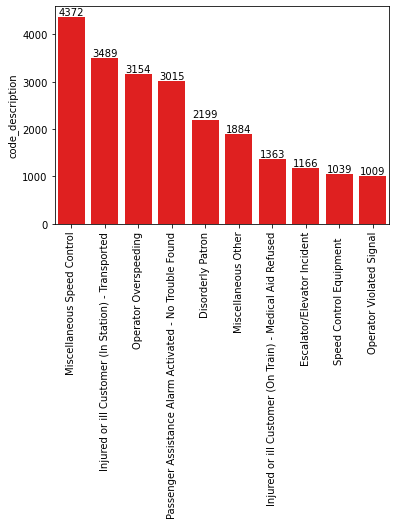

In [12]:
# What are the 10 most common delays?
mc_delays = pd.DataFrame(df2.code_description.value_counts().nlargest(10))

print("Speeding issues are a common cause of delays. 3 of the top 10 incident types relate to speeding. Passenger behaviour or illness are another common cause of delays (4 of the top 10 incidents)")

# creating the bar plot
ax = sns.barplot(x=mc_delays.index, y='code_description', data=mc_delays, color='red')
#add axis titles
plt.xticks(rotation=90)
#bar label
for container in ax.containers:
    ax.bar_label(container)

plt.show()

Overall the numbers for least common are low, so we'd likely need higher level categories.  Mechanical and infrastructure issues seem to be the least common. 


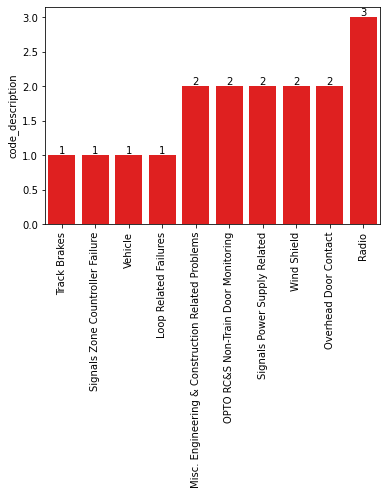

In [13]:
# What are the 10 least common delays?
lc_delays = pd.DataFrame(df2.code_description.value_counts().nsmallest(10))

print("Overall the numbers for least common are low, so we'd likely need higher level categories. ",
      "Mechanical and infrastructure issues seem to be the least common. ")

# creating the bar plot
ax = sns.barplot(x=lc_delays.index, y='code_description', data=lc_delays, color='red')
#add axis titles
plt.xticks(rotation=90)
#bar label
for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [14]:
#where do the delays occur (station or train) ?
#add a binary location variable using vehicle == 0 
df2['location'] = np.where(df2.vehicle == '0', 'Station','Vehicle')

print(df2.location.value_counts())
print("\n","Delays are nearly 3x more common on vehicles than in stations")

Vehicle    29167
Station    10792
Name: location, dtype: int64

 Delays are nearly 3x more common on vehicles than in stations


In [15]:
# where are the stations with the most station delays? 
df2[df2['location']=='Station'].station.value_counts().nlargest(10)

YUS/BD/SHEPPARD SUBWAY    772
BLOOR DANFORTH SUBWAY     599
BLOOR STATION             393
KENNEDY BD STATION        364
YONGE UNIVERSITY LINE     338
FINCH STATION             335
UNION STATION             251
DUNDAS STATION            224
KIPLING STATION           215
WILSON STATION            197
Name: station, dtype: int64

In [16]:
# where are the stations with the most station delays? 
print(df2[df2['location']=='Station'].station.value_counts().nsmallest(10))

print("\n",'There are similar magnitude differences between the stations with the most and least delays')

SUBWAY CLOSURE - WILSO    1
OSSINGTION STAITON        1
KIPLING TO ISLINGTON      1
SHEPPARD-YONGE TAIL TR    1
KING COMMERCE             1
120 CARTWRIGHT AVE        1
UNION TO KING             1
EGLINTON TO LAWRENCE      1
DON MLLS STATION          1
UNION, MAIN, KENNEDY S    1
Name: station, dtype: int64

 There are similar magnitude differences between the stations with the most and least delays


In [17]:
#What are the summary stats for the delays?
print(df2['min_delay'].describe())

#A lot of the records list no delays, so that skews the mean 

print("\n","num records >10 min delay: ", sum(df2['min_delay']>=10))
print("% records >10 min delay: ",sum(df2['min_delay']>=10)/len(df2))
print("4.5% of delays are longer than 10 min")

count    39959.000000
mean         2.365400
std          8.487794
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        515.000000
Name: min_delay, dtype: float64

 num records >10 min delay:  1802
% records >10 min delay:  0.04509622362921995
4.5% of delays are longer than 10 min


In [18]:
#if we focus on the most common issues 
#average delay for the 10 most common issues
print(df2.groupby(df2[df2['code_description'].isin(mc_delays.index) == True]['code_description'])['min_delay'].mean().sort_values(ascending=False))

print("\n","The average delay for the most common issues, varies greatly (from 0 to 3 min)")

code_description
Injured or ill Customer (On Train) - Medical Aid Refused    3.838591
Disorderly Patron                                           3.309686
Operator Violated Signal                                    1.577800
Miscellaneous Other                                         1.108280
Passenger Assistance Alarm Activated - No Trouble Found     0.852405
Speed Control Equipment                                     0.340712
Miscellaneous Speed Control                                 0.166285
Injured or ill Customer (In Station) - Transported          0.143021
Operator Overspeeding                                       0.107166
Escalator/Elevator Incident                                 0.004288
Name: min_delay, dtype: float64

 The average delay for the most common issues, varies greatly (from 0 to 3 min)


In [19]:
#What are the issues with the longest delays
print(df2[df2['min_delay']>=10].code_description.value_counts().nlargest(10))

print("\n", "Some of the reasons for longer delays are similar to the most common ones. ",
      "But there are some new reasons, like unauthorized people on the tracks or getting hit by a train,major infrastructure projects (e.g., ATC project), and fire.")



Injured or ill Customer (On Train) - Transported            304
Unauthorized at Track Level                                 151
Disorderly Patron                                           134
Fire/Smoke Plan B - Source TTC                              101
Injured or ill Customer (On Train) - Medical Aid Refused     94
ATC Project                                                  82
Passenger Other                                              67
Priority One - Train in Contact With Person                  56
Assault / Patron Involved                                    51
Emergency Alarm Station Activation                           45
Name: code_description, dtype: int64

 Some of the reasons for longer delays are similar to the most common ones.  But there are some new reasons, like unauthorized people on the tracks or getting hit by a train,major infrastructure projects (e.g., ATC project), and fire.


## EDA
- How many incidents per day?
- Are there any trends in the delays?
- When are delays occuring (e.g., day of the week, hour of the day)?


In [20]:
#When do the delays occur? 
# - # delays per day over the course of the dataset - is there a trend (increasing, seasonal, etc)
# - Is there a relationship between delay type and time 

#Create a dataframe with the count of incidents per day (ipd)
ipd = pd.DataFrame(df2.groupby(df2['date'].dt.to_period('D')).size(), columns = ['incidents'])
ipd.head()


,incidents
date,
2018-01-01,58
2018-01-02,75
2018-01-03,67
2018-01-04,63
2018-01-05,78


In [21]:
print(ipd.incidents.describe())

print("\n","On average there are 54 incidents per day. There is a lot of spread and the max number is twice the mean")

count    730.000000
mean      54.738356
std       14.623629
min       22.000000
25%       44.000000
50%       55.000000
75%       64.000000
max      108.000000
Name: incidents, dtype: float64

 On average there are 54 incidents per day. There is a lot of spread and the max number is twice the mean


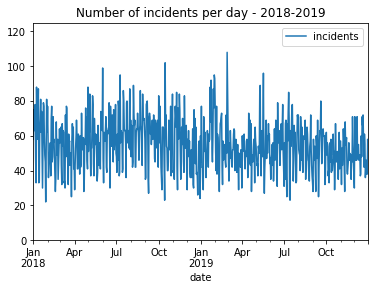


 The trend looks fairly flat.


In [22]:
# plot the trends
ax = ipd.plot()
ax.set_title("Number of incidents per day - 2018-2019")
ax.set_ylim(0,125)

plt.show()

print("\n The trend looks fairly flat.")


There may be a bit of a rise at the end of 2018. There may be a slight downward trend. It would be worth exploring the timeseries further for trends


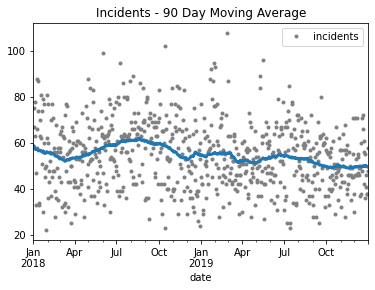

In [23]:
moving_average = ipd.rolling(
    window=90,       # 30 day window
    center=True,      # puts the average at the center of the window
    min_periods=45,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = ipd.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Incidents - 90 Day Moving Average", legend=False,
);
print("\nThere may be a bit of a rise at the end of 2018. There may be a slight downward trend. It would be worth exploring the timeseries further for trends")



In [24]:
#are there days of the week with more delays? 
#Create a dataframe with the count of incidents per day of the week (idow)
idow = pd.DataFrame(df2.groupby(df2['day']).size(), columns = ['incidents'])
idow


,incidents
day,
Monday,6324
Tuesday,6210
Wednesday,6243
Thursday,6300
Friday,6326
Saturday,4652
Sunday,3904



 There are fewer delays on Saturday and Sunday.


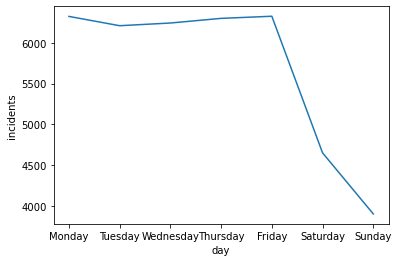

In [25]:
#plot the days of the week
sns.lineplot(data=idow, x=idow.index, y='incidents')

print("\n There are fewer delays on Saturday and Sunday.")

In [26]:
#Are the mean delays different on different days? 
print(df2.groupby(df2['date'].dt.weekday)['min_delay'].mean())

print("\nThere is very little variability in the average delay by day of the week.")

date
0    2.393738
1    2.461514
2    2.113888
3    2.221270
4    2.371009
5    2.759458
6    2.322746
Name: min_delay, dtype: float64

There is very little variability in the average delay by day of the week.


      incidents
date           
1          3744
2          3068
3          3124
4          3147
5          3466
6          3398
7          3581
8          3567
9          3325
10         3299
11         3201
12         3039

 There were more delays in January and in the summer months. Further analysis of seasonality or cycles would be interesting


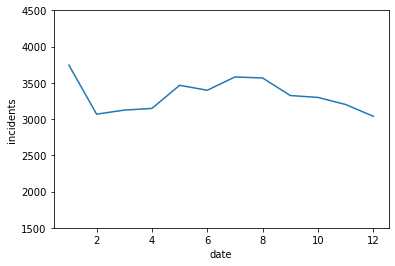

In [27]:
#are there months of the year with more delays? 
#Create a dataframe with the count of incidents per month (moy)
imoy = pd.DataFrame(df2.groupby(df2.date.dt.month).size(), columns = ['incidents'])
print(imoy)
#plot the days of the week
ax = sns.lineplot(data=imoy, x=imoy.index, y='incidents')
ax.set_ylim(1500,4500)

print("\n There were more delays in January and in the summer months. Further analysis of seasonality or cycles would be interesting")


In [28]:
#Are the mean delays different on different days? 
print(df2.groupby(df2['date'].dt.month)['min_delay'].mean())
print("\nThere is very a bit more variability in the average delay by month.")

date
1     2.616720
2     2.866037
3     2.554417
4     2.368605
5     2.236295
6     2.519129
7     2.221167
8     2.179983
9     1.866466
10    2.295544
11    2.293346
12    2.413294
Name: min_delay, dtype: float64

There is very a bit more variability in the average delay by month.


In [29]:
#are there hours of the day with more delays? 
#Create a dataframe with the count of incidents per hour of the day (hod)
hod = pd.DataFrame(df2.groupby(pd.to_datetime( df2['time'], format="%H:%S").dt.hour).size(), columns = ['incidents'])
hod


,incidents
time,
0,1123
1,1023
2,495
3,119
4,243
5,1224
6,2291
7,2127
8,2851



The number of delays peaks at 8am and again at 5pm (during rush hour). There are also a large number of delays reported at 6am and at 10pm. There are fewer delays from 2-4am when the subay is closed, but still recorded incidents.


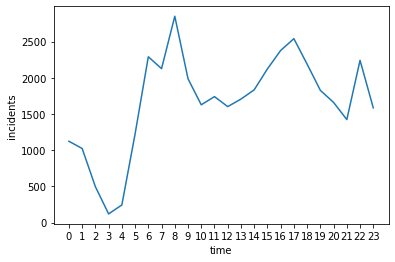

In [30]:
#plot the days of the week
sns.lineplot(data=hod, x=hod.index, y='incidents')
plt.xticks(np.arange(0, len(hod)))
print("\nThe number of delays peaks at 8am and again at 5pm (during rush hour). There are also a large number of delays reported at 6am and at 10pm. There are fewer delays from 2-4am when the subay is closed, but still recorded incidents.")

## Summary & Next Steps

- There are relationships between the types of delays, where they occur and length of the delays 
- Time series analysis has a lot of promise for this data set because there are seasons & cycles in the data and possibly some trends (I wonder if this was the time when Andy Byford was the head of the TTC and he tried to reduce delays?)
- Long delays (of greater than 10 minutes) are not very common (only 4.5%). I would need to address this left skewness in the data in models predicting the length of delays. 
- The data set contains delay records between 2am and 4am when the subway is closed.  Further exploration of the type of delay reporting during that time may be helpful before predictive modelling. The dataset may contain data related to incidents, not specifically delays.
- Depending on the project goals, I'd like to do more cleaning up of the codes and station names, etc. as there's redundancy before testing out some different models and features. 
- Passenger behaviour is a common reason for delay. It may be helpful to incorporate information about ridership numbers when building predictive models.  Delays may be more common when there are more passengers. 
